In [1]:
# import needed libraries

# for statistical testing
from enum import Enum
import pandas as pd
from scipy.stats import ttest_ind
import scipy.stats as stats

# for machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

# global vars

# total number of categories
totalCat = 0 
# the sum of categories with significant classes
sumSigCat = 0
# the number of significant classes for a certain category
sigClassCount = 0
# dict which keeps track of the number of times each class appeared
bactClassDict = {}

train_inputs = []
train_outputs = []
test_inputs = []
test_outputs = []

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# enums for all the categories and their column number
class Col(Enum):
    Gender = 1
    Menstrual = 2 
    SleepPrior = 3 
    Prescription = 4 
    OralAntibiotics = 5 
    TopAntibiotics = 6 
    Eyes = 7 
    Hands = 8 
    Race = 9 
    Feeling = 10 
    Symptoms = 11 
    Facial = 12 
    LastVomit = 13 
    EnvAllergies = 14 
    Snore = 15 
    GrindTeeth = 16 
    EarInfect = 17 
    AllergyTime = 18 
    Skin = 19 
    OralSurgery = 20 
    HeartDisease = 21 
    BadTeeth = 22 
    EatPrior = 23 
    DrinkPrior = 24 
    GumDay = 25 
    YogurtWeek = 26 
    TeaWeek = 27 
    CoffeeWeek = 28 
    SodaWeek = 29 
    FastFoodWeek = 30 
    EatOutWeek = 31 
    Straw = 32 
    AddedSugar = 33 
    Spicy = 34 
    ShareDrink = 35 
    MeatWeek = 36 
    FreshWeek = 37 
    BrushTongue = 38 
    BrushTeethWeek = 39 
    TobaccoWeek = 40 
    FlossWeek = 41 
    DentistYear = 42 
    Toothbrush = 43 
    Mouthwash = 44 
    Toothpaste = 45 
    WashHandsEat = 46 
    WashHandsRestroom = 47 
    ChangeToothbrush = 48 
    BiteNails = 49 
    OrthoDevice = 50 
    Device = 51 
    Stress = 52 
    HandleStress = 53 
    Organized = 54 
    RateStress = 55 
    AvgSleep = 56 
    AvgWork = 57 
    Setting = 58 
    Environment = 59 
    UpDown = 60 
    Weight = 61 
    ExerciseMonth = 62 
    Transportation = 63 
    Orientation = 64 
    NearDogsWeek = 65 
    NearCatsWeek = 66 
    ShareBathroom = 67 
    BooksYear = 68 
    Alarms = 69 
    Patience = 70 
    Lipstick = 71 
    IntroExtro = 72 
    Relgious = 73 
    OptiPessi = 74 
    SexuallyActive = 75 
    OralSex = 76 
    Music = 77 
    AvgGrade = 78 
    RateHappy = 79 
    Arts = 80 
    Kiss = 81 
    Roommates = 82 
    
# enum for type of test
class Test(Enum):
    Ttest = 1
    Anova = 2

In [3]:
# helper methods, most of which manipulates data from master spreadsheet so that it's easier to process

def sleepPrior(category, data):
    if category != Col.SleepPrior:
        return data
    
    #if SleepPrior, manipulate the data so that the subcategories don't go over 7
    #also create new subcategories to make it more general
    data[category.name] = data[category.name].replace(['0', '1', '2', '3'], 'less than 4')
    data[category.name] = data[category.name].replace(['4', '5', '6', '7'], '4 to 7')
    data[category.name] = data[category.name].replace(['8', '9', '10', '11', '12'], 'more than 7')
    return data


def prescription(category, data):
    if category != Col.Prescription:
        return data
    
    #manipulate the data so that if the prescription column has a specific prescription, replace with yes
    data[category.name] = data[category.name].replace(['None', 'none', 'no '], 'no')
    data.loc[(data[category.name] != 'no') & (data[category.name] != 'No') & (data[category.name] != 'nan'), 
             category.name] = 'yes'
    return data


def eyes(category, data):
    if category != Col.Eyes:
        return data
    
    #manipulate the data to make it more generic
    data[category.name] = data[category.name].replace('Green/blue/gold mix', 'hazel')
    return data


def perWeek(category, data):
    if category not in (Col.TeaWeek, Col.CoffeeWeek, Col.SodaWeek, Col.FastFoodWeek, Col.BrushTeethWeek, 
                        Col.FlossWeek, Col.BooksYear, Col.GumDay, Col.EatOutWeek, Col.AvgSleep, Col.AvgWork, 
                        Col.ExerciseMonth) :
        return data
    
    #manipulate the data so results don't show as dates
    data[category.name] = data[category.name].replace('5-Jan', '1-5')
    data[category.name] = data[category.name].replace('10-Jun', '6-10')
    data[category.name] = data[category.name].replace('15-Nov', '11-15')
    
    data[category.name] = data[category.name].replace('2-Jan', '1-2')
    data[category.name] = data[category.name].replace('4-Mar', '3-4')
    data[category.name] = data[category.name].replace('6-May', '5-6')
    data[category.name] = data[category.name].replace('8-Jul', '7-8')
    data[category.name] = data[category.name].replace('10-Sep', '9-10')
    data[category.name] = data[category.name].replace('12-Nov', '11-12')
    
    if category == Col.FlossWeek:
        data[category.name] = data[category.name].replace('5-Nov', '11-15')
    
    return data


def numToWords(category, data):
    if category not in (Col.AddedSugar, Col.Straw, Col.Lipstick):
        return data
    
    #manipulate the data so results don't show as dates
    data[category.name] = data[category.name].replace('1', 'never')
    data[category.name] = data[category.name].replace('2', 'rarely')
    data[category.name] = data[category.name].replace('3', 'sometimes')
    data[category.name] = data[category.name].replace('4', 'often')
    data[category.name] = data[category.name].replace('5', 'always')
    
    return data


def mouthwash(category, data):
    if category != Col.Mouthwash:
        return data
    
    #manipulate the data so that results are in form of yes or no
    data.loc[(data[category.name] != 'never') & (data[category.name] != 'No') & (data[category.name] != 'nan'), 
             category.name] = 'yes'
    data[category.name] = data[category.name].replace('never', 'no')
    return data


def religious(category, data):
    if category != Col.Relgious:
        return data
    
    #manipulate the data so that results are in form of yes or no
    data.loc[(data[category.name] != 'No') & (data[category.name] != 'nan'), category.name] = 'yes'
    data[category.name] = data[category.name].replace('never', 'no')
    return data


def orientation(category, data):
    if category != Col.Orientation:
        return data
    
    #fix spelling mistakes, change bicurious to bisexual to generalize data
    data[category.name] = data[category.name].replace('hetrosexual', 'heterosexual')
    data[category.name] = data[category.name].replace(['bicurious', 'Bicurious'], 'bisexual')
    return data

In [4]:
# helper method which creates a neural network for said category, graphing accuracy and loss
# we want max accuracy and min loss
# tutorial: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb

def keras(category):
    # create nn model
    model = tf.keras.Sequential()
    model.add(layers.Dense(units=4,input_shape=(sigClassCount,)))
    model.add(layers.Dense(64, activation='selu'))
    model.add(layers.Dropout (0.3))
    model.add(layers.Dense(64, activation='selu'))
    model.add(layers.Dense(64, activation='selu'))
    model.add(layers.Dropout (0.3))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='Adamax',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(np.array(train_inputs), np.array(train_outputs), epochs=200, verbose=0,
                  validation_data=(np.array(test_inputs), np.array(test_outputs)))

    
    # graph code from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

    # graph accuracy over epochs
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    title = category.name + ' Model Accuracy'
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['training', 'testing'], loc='lower left')
    plt.ylim(0,1)
    plt.show()
    
    # get largest accuracy value
    index = 0
    maxVal = 0
    maxInd = 0
    for value in history.history['val_acc']:
        if value > maxVal:
            maxVal = value
            maxInd = index
        index += 1
    
    # graph loss over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    title = category.name + ' Model Loss'
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training', 'testing'], loc='lower left')
    plt.ylim(0,1.8)
    plt.show()
    
    # get smallest loss value
    index = 0
    minVal = 100
    minInd = 0
    for value in history.history['val_loss']:
        if value < minVal:
            minVal = value
            minInd = index
        index += 1
    
    print("Largest Testing Accuracy :: ", "{:4.4f}".format(maxVal))
    print("Epoch 1st Appeared :: ", repr(maxInd))
    print("Smallest Testing Loss :: ", "{:4.4f}".format(minVal))
    print("Epoch 1st Appeared :: ", repr(minInd), "\n")
    
    # get largest acc with smallest loss
    index = 0
    maxVal = 0
    minVal = 100
    saveInd = 0
    for i in range(0, len(history.history['val_acc'])):
        if history.history['val_acc'][i] >= maxVal:
            if history.history['val_loss'][i] < minVal:
                maxVal = history.history['val_acc'][i]
                minVal = history.history['val_loss'][i]
                saveInd = index
                
        index += 1
        
    print("Highest Acc, Lowest Loss :: ", "{:4.4f}".format(maxVal), "{:4.4f}".format(minVal))
    print("Epoch 1st Appeared :: ", repr(saveInd))

In [13]:
  
def runTests(data, category, outputMap, showAllClasses):
    global totalCat
    global sumSigCat
    global sigClassCount
    global bactClassDict
    global train_inputs
    global train_outputs
    global test_inputs
    global test_outputs
    subcategory = []
    categoryDF = []
    bactClasses = []
    sigClasses = []
    inputs = []
    train_inputs = []
    train_outputs = []
    test_inputs = []
    test_outputs = []
    
    #decided not to do these groups
    if category.name in ('Menstrual', 'Race', 'Feeling', 'Symptoms', 'EnvAllergies', 'Skin', 'EatPrior',
                        'DrinkPrior', 'TobaccoWeek', 'Toothpaste', 'BiteNails', 'Transportation', 'Environment', 
                        'NearDogsWeek', 'NearCatsWeek'):
        return False
    
    
    # fix the inconsistant data
    data = sleepPrior(category, data)
    data = prescription(category, data)
    data = eyes(category, data)
    data = perWeek(category, data)
    data = numToWords(category, data)
    data = mouthwash(category, data)
    data = religious(category, data)
    data = orientation(category, data)

    #change the category into its own separate dataframe

    #get list of subcategories
    try:
        data[category.name] = data[category.name].str.lower()
    except:
        data[category.name]
    subcategory = data[category.name].drop_duplicates().values.tolist()
    
    #remove nans (where people didn't put in an answer)
    try:
        subcategory = [subcat.lower().strip() for subcat in subcategory if str(subcat) != 'nan' 
                   and str(subcat) != 'don\'t know' and str(subcat) != 'do not know' and str(subcat) != 'don?t know']
    except:
        subcategory = [subcat for subcat in subcategory if str(subcat) != 'nan' 
                   and str(subcat) != 'don\'t know' and str(subcat) != 'do not know' and str(subcat) != 'don?t know']
        
    #remove any more duplicates
    subcategory = list(set(subcategory))

    #remove outliers/format the data for specific categories
    if category == Col.Spicy:
        subcategory.remove('sometimes')
    if category == Col.Hands:
        subcategory.remove('ambidextrous')
    if category == Col.BrushTeethWeek:
        subcategory.remove('42689');
    

    #decide on which test to use
    if len(subcategory) == 2:
        test = Test.Ttest
    else:
        test = Test.Anova
        
    #load dataframes for each subcategory of all bacterial classes\n",
    for x in range(0, len(subcategory)):
        categoryDF.append(data[data[category.name] == subcategory[x]].iloc[:, 83:125])
        
    print("Category :: ", category.name)
    print("Subcategories :: ", subcategory, "\n")
    print("BACTERIA CLASS ", "P-VALUE")
        
    #go through all bacterial classes to perform tests on them
    sigClassCount = 0
    totalCat += 1
    markCat = False
    for x in range(0, 42):
        
        #perform t-test if applicable
        if test == Test.Ttest:
            ttest = ttest_ind(categoryDF[0].iloc[:, x],categoryDF[1].iloc[:, x])
            pvalue = ttest[1]
            
        #perform anova test is applicable
        if test == Test.Anova:
            #keep track of how many subcategories there are to put into anova test
            arg = []
            for y in range(0, len(subcategory)):
                arg.append(categoryDF[y].iloc[:, x])
            anova = stats.f_oneway(*(a for a in arg))
            pvalue = anova[1]

        #keep a list of all bacteria classes and their index
        if len(bactClasses) != 42:
            bactClasses.append(categoryDF[0].iloc[:,x].name)

        #print classes that are significant
        if pvalue <= 0.05 or showAllClasses:
            markCat = True
            #keep track of significant classes
            sigClassCount += 1
            className = categoryDF[0].iloc[:,x].name
            if className not in bactClassDict:
                bactClassDict[className] = 1
            else:
                bactClassDict[className] += 1
            sigClasses.append(className)

            print(categoryDF[0].iloc[:,x].name, " -- {:4.4f}".format(pvalue))
    
    if markCat:
        sumSigCat += 1
        
    if sigClassCount == 0:
        print("no significant classes")
        return False

   # print out info for categories with high numbers of significant classes  
#     if sigClassCount >= 4: 
#         catData = []
#         print(sigClassCount)
#         print(sigClasses)
#         for subcat in data[category.name]:
#             if subcat in subcategory:
#                 catData.append(subcat)
#         print(len(catData))
#         print(catData)

    # UNCOMMENT BELOW HERE FOR NN TESTING

    #get and set inputs Design 2
    for index, row in data.iterrows():
        classValue = []
        for c in sigClasses:
            if row[category.name] in subcategory:
                classValue.append(row[c])
        if row[category.name] in subcategory:
            inputs.append(classValue)
    
    #add subcategories to outputMap
    outputMap[category.name] = subcategory
    
    #get and set outputs so that it looks like [a,b,c]
    outputs = []
    for index, row in data.iterrows():
        if row[category.name] in subcategory:
            outputs.append(row[category.name])
    
    #replace string outputs with numbers
    if outputs and isinstance(outputs[0], str):
        for i in range(0, len(outputs)):
            outputs[i] = subcategory.index(outputs[i])
    
    #separate training and testing data
    for i in range(0, len(inputs)):
        if i % 2 == 1:
            train_inputs.append(inputs[i])
            train_outputs.append(outputs[i])
        else:
            test_inputs.append(inputs[i])
            test_outputs.append(outputs[i])  
            
    print("\nTotal significant classes :: ", repr(sigClassCount))
    print("Training size :: ", repr(len(train_inputs)))
    print("Testing size :: ", repr(len(test_inputs)))
    
    # do machine learning stuff
    keras(category)

Category ::  Gender
Subcategories ::  ['male', 'female'] 

BACTERIA CLASS  P-VALUE
Bacilli  -- 0.0401
Fusobacteria  -- 0.0000
Epsilonproteobacteria  -- 0.0211
Alphaproteobacteria  -- 0.0387
Thermotogae  -- 0.0122

Total significant classes ::  5
Training size ::  53
Testing size ::  53


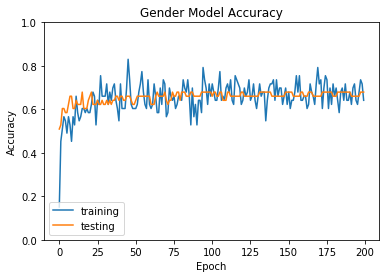

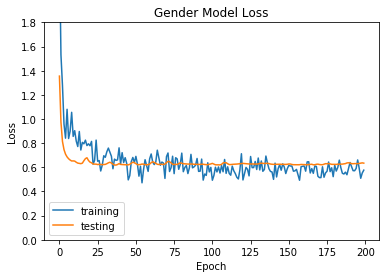

Largest Testing Accuracy ::  0.6792
Epoch 1st Appeared ::  15
Smallest Testing Loss ::  0.6186
Epoch 1st Appeared ::  37 

Highest Acc, Lowest Loss ::  0.6792 0.6345
Epoch 1st Appeared ::  15

--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  SleepPrior
Subcategories ::  ['4 to 7', 'less than 4', 'more than 7'] 

BACTERIA CLASS  P-VALUE
Flavobacteriia  -- 0.0388
Sphingobacteriia  -- 0.0262

Total significant classes ::  2
Training size ::  52
Testing size ::  52


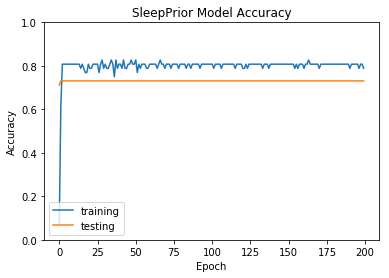

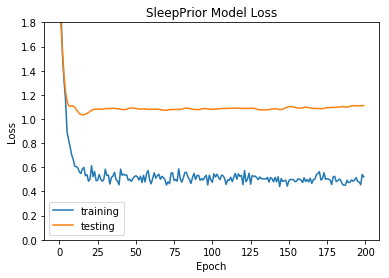

Largest Testing Accuracy ::  0.7308
Epoch 1st Appeared ::  1
Smallest Testing Loss ::  1.0343
Epoch 1st Appeared ::  15 

Highest Acc, Lowest Loss ::  0.7308 1.0343
Epoch 1st Appeared ::  15

--------------------------------------------------------------------------

Category ::  Prescription
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  OralAntibiotics
Subcategories ::  ['within the last year', 'within the last month', 'not within the last year', 'within the last week', 'within the last 6 months'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  TopAntibiotics
Subcategories ::  ['within the last year', 'within the last month', 'not within the last year', 'within the last week', 'within the last 6 months', 'not with in the last year'] 

BACTERIA CLASS  P-VALUE
Epsilonproteob

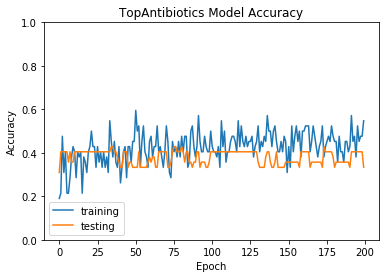

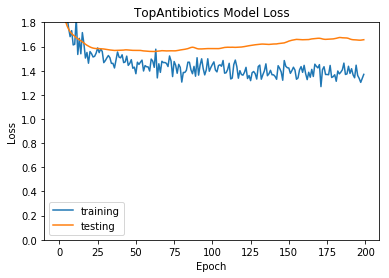

Largest Testing Accuracy ::  0.4286
Epoch 1st Appeared ::  173
Smallest Testing Loss ::  1.5588
Epoch 1st Appeared ::  62 

Highest Acc, Lowest Loss ::  0.4286 1.5642
Epoch 1st Appeared ::  75

--------------------------------------------------------------------------

Category ::  Eyes
Subcategories ::  ['brown', 'green', 'hazel', 'black', 'blue'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  Hands
Subcategories ::  ['right', 'left'] 

BACTERIA CLASS  P-VALUE
Gammaproteobacteria  -- 0.0025
Sphingobacteriia  -- 0.0455
Erysipelotrichi  -- 0.0356
Spirochaetes  -- 0.0349
Nostocophycideae  -- 0.0257
Mollicutes  -- 0.0304

Total significant classes ::  6
Training size ::  51
Testing size ::  52


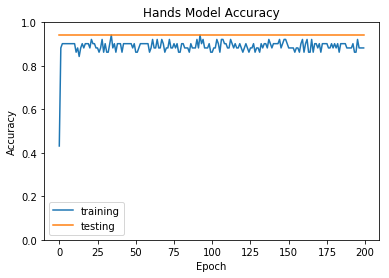

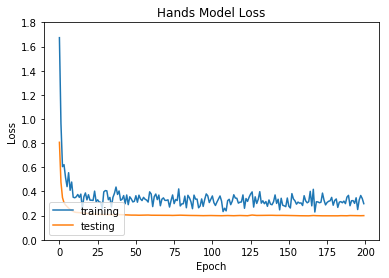

Largest Testing Accuracy ::  0.9423
Epoch 1st Appeared ::  0
Smallest Testing Loss ::  0.1978
Epoch 1st Appeared ::  180 

Highest Acc, Lowest Loss ::  0.9423 0.1978
Epoch 1st Appeared ::  180

--------------------------------------------------------------------------


--------------------------------------------------------------------------


--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  Facial
Subcategories ::  ['oily', 'dry', 'combination'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  LastVomit
Subcategories ::  ['within the last year', 'today', 'within the last month', 'within the last week', 'more than a year ago'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------


-----------------------------

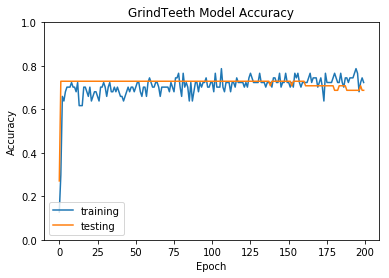

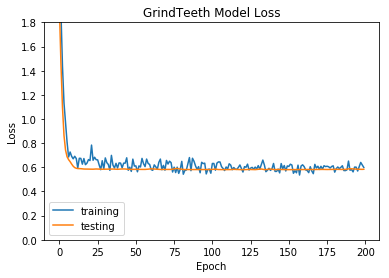

Largest Testing Accuracy ::  0.7292
Epoch 1st Appeared ::  1
Smallest Testing Loss ::  0.5807
Epoch 1st Appeared ::  149 

Highest Acc, Lowest Loss ::  0.7292 0.5807
Epoch 1st Appeared ::  149

--------------------------------------------------------------------------

Category ::  EarInfect
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  AllergyTime
Subcategories ::  ['chronically', 'never', 'seasonally', 'rarely'] 

BACTERIA CLASS  P-VALUE
Actinobacteria  -- 0.0398

Total significant classes ::  1
Training size ::  51
Testing size ::  51


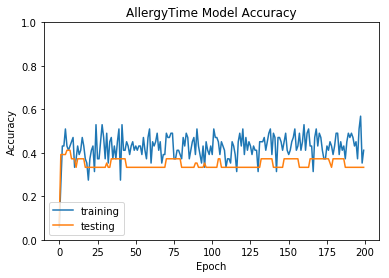

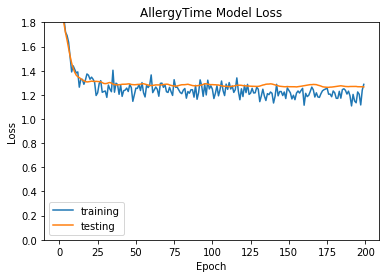

Largest Testing Accuracy ::  0.4118
Epoch 1st Appeared ::  6
Smallest Testing Loss ::  1.2622
Epoch 1st Appeared ::  176 

Highest Acc, Lowest Loss ::  0.4118 1.5198
Epoch 1st Appeared ::  7

--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  OralSurgery
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
Flavobacteriia  -- 0.0109
Sphingobacteriia  -- 0.0401

Total significant classes ::  2
Training size ::  49
Testing size ::  50


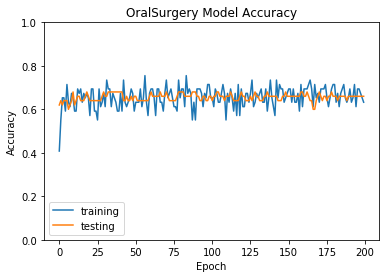

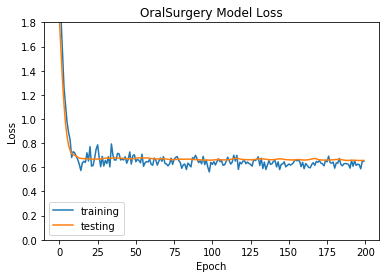

Largest Testing Accuracy ::  0.6800
Epoch 1st Appeared ::  9
Smallest Testing Loss ::  0.6566
Epoch 1st Appeared ::  198 

Highest Acc, Lowest Loss ::  0.6800 0.6611
Epoch 1st Appeared ::  159

--------------------------------------------------------------------------

Category ::  HeartDisease
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  BadTeeth
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
Gammaproteobacteria  -- 0.0201

Total significant classes ::  1
Training size ::  47
Testing size ::  48


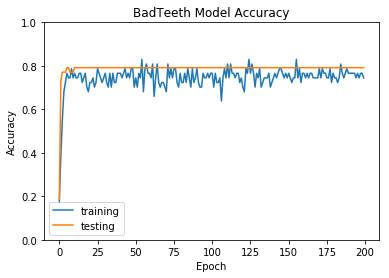

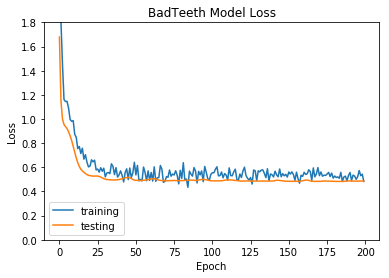

Largest Testing Accuracy ::  0.7917
Epoch 1st Appeared ::  5
Smallest Testing Loss ::  0.4828
Epoch 1st Appeared ::  184 

Highest Acc, Lowest Loss ::  0.7917 0.4828
Epoch 1st Appeared ::  184

--------------------------------------------------------------------------


--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  GumDay
Subcategories ::  ['5-6', '1-2', '3-4', '0'] 

BACTERIA CLASS  P-VALUE
Actinobacteria  -- 0.0199

Total significant classes ::  1
Training size ::  41
Testing size ::  41


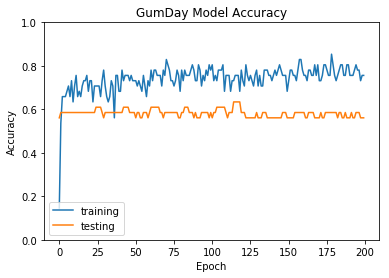

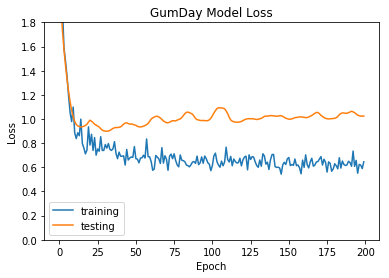

Largest Testing Accuracy ::  0.6341
Epoch 1st Appeared ::  114
Smallest Testing Loss ::  0.8988
Epoch 1st Appeared ::  31 

Highest Acc, Lowest Loss ::  0.6098 0.9196
Epoch 1st Appeared ::  27

--------------------------------------------------------------------------

Category ::  YogurtWeek
Subcategories ::  [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0] 

BACTERIA CLASS  P-VALUE
Bacteroidia  -- 0.0293
Gammaproteobacteria  -- 0.0054

Total significant classes ::  2
Training size ::  51
Testing size ::  51


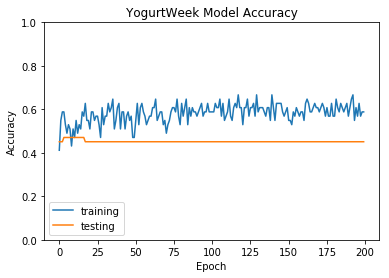

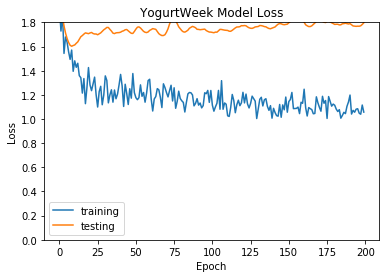

Largest Testing Accuracy ::  0.4706
Epoch 1st Appeared ::  3
Smallest Testing Loss ::  1.6020
Epoch 1st Appeared ::  8 

Highest Acc, Lowest Loss ::  0.4706 1.6020
Epoch 1st Appeared ::  8

--------------------------------------------------------------------------

Category ::  TeaWeek
Subcategories ::  ['6-10', '0', '11-15', '1-5', '16-20'] 

BACTERIA CLASS  P-VALUE
Fusobacteria  -- 0.0007
Epsilonproteobacteria  -- 0.0014
Spirochaetes  -- 0.0090

Total significant classes ::  3
Training size ::  50
Testing size ::  50


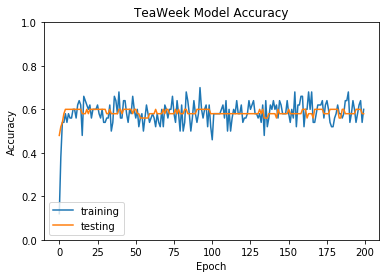

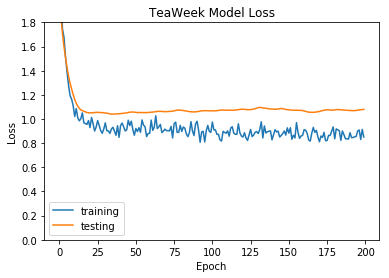

Largest Testing Accuracy ::  0.6000
Epoch 1st Appeared ::  82
Smallest Testing Loss ::  1.0407
Epoch 1st Appeared ::  35 

Highest Acc, Lowest Loss ::  0.6000 1.0424
Epoch 1st Appeared ::  33

--------------------------------------------------------------------------

Category ::  CoffeeWeek
Subcategories ::  ['21-25', '6-10', '0', '11-15', '1-5', '16-20'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  SodaWeek
Subcategories ::  ['21-25', '6-10', '0', '11-15', '1-5'] 

BACTERIA CLASS  P-VALUE
Sphingobacteriia  -- 0.0339
Thermotogae  -- 0.0437

Total significant classes ::  2
Training size ::  50
Testing size ::  51


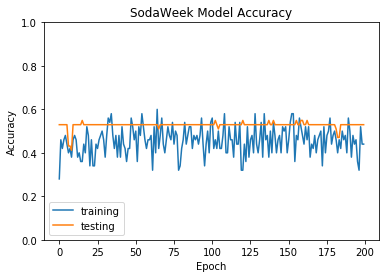

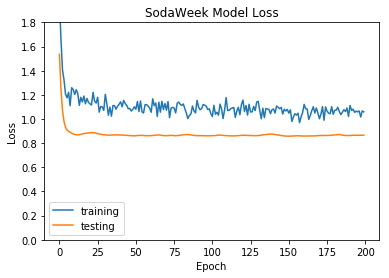

Largest Testing Accuracy ::  0.5490
Epoch 1st Appeared ::  140
Smallest Testing Loss ::  0.8577
Epoch 1st Appeared ::  150 

Highest Acc, Lowest Loss ::  0.5294 0.8577
Epoch 1st Appeared ::  150

--------------------------------------------------------------------------

Category ::  FastFoodWeek
Subcategories ::  ['6-10', '1-5', '0', '11-15'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  EatOutWeek
Subcategories ::  ['13-14', '7-8', '11-12', '0', '9-10', '3-4', '5-6', '1-2', '>14'] 

BACTERIA CLASS  P-VALUE
Gammaproteobacteria  -- 0.0427
Erysipelotrichi  -- 0.0074
Mollicutes  -- 0.0159
Chlamydiia  -- 0.0093
GroupII  -- 0.0069
Deinococci  -- 0.0086
Synergistia  -- 0.0096
Oscillatoriophycideae  -- 0.0117
Opitutae  -- 0.0093
Thermoprotei  -- 0.0084
Anaerolineae  -- 0.0085
Deferribacteres  -- 0.0077
Nitriliruptoria  -- 0.0085
Acidobacteria  -- 0.0086
Thermotogae  -- 0.0099
Synechococcophycideae  -

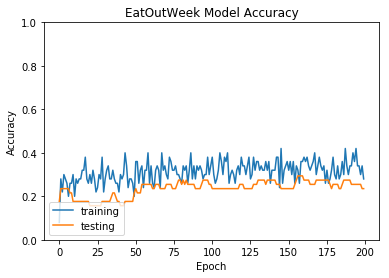

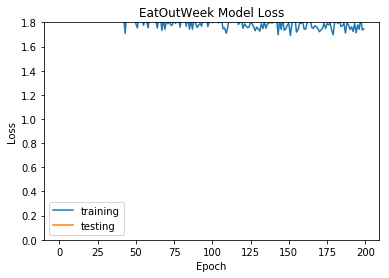

Largest Testing Accuracy ::  0.2941
Epoch 1st Appeared ::  156
Smallest Testing Loss ::  2.1822
Epoch 1st Appeared ::  5 

Highest Acc, Lowest Loss ::  0.2353 2.1822
Epoch 1st Appeared ::  5

--------------------------------------------------------------------------

Category ::  Straw
Subcategories ::  ['often', 'usually', 'always', 'sometimes', 'never', 'rarely'] 

BACTERIA CLASS  P-VALUE
Bacteroidia  -- 0.0315

Total significant classes ::  1
Training size ::  49
Testing size ::  50


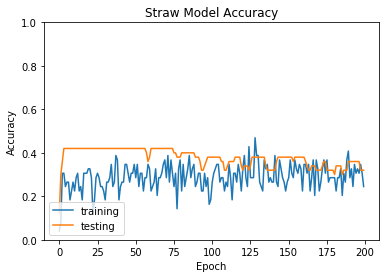

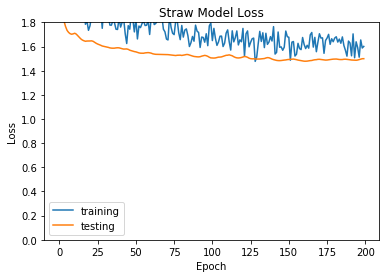

Largest Testing Accuracy ::  0.4200
Epoch 1st Appeared ::  3
Smallest Testing Loss ::  1.4783
Epoch 1st Appeared ::  161 

Highest Acc, Lowest Loss ::  0.4200 1.5282
Epoch 1st Appeared ::  74

--------------------------------------------------------------------------

Category ::  AddedSugar
Subcategories ::  ['often', 'always', 'sometimes', 'never', 'rarely'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  Spicy
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
Actinobacteria  -- 0.0113

Total significant classes ::  1
Training size ::  49
Testing size ::  49


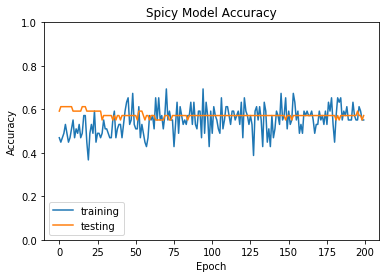

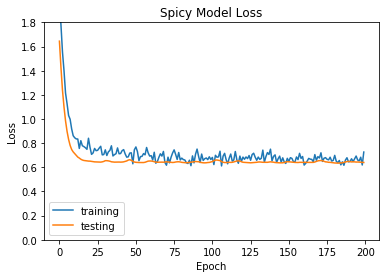

Largest Testing Accuracy ::  0.6122
Epoch 1st Appeared ::  15
Smallest Testing Loss ::  0.6348
Epoch 1st Appeared ::  182 

Highest Acc, Lowest Loss ::  0.6122 0.6548
Epoch 1st Appeared ::  17

--------------------------------------------------------------------------

Category ::  ShareDrink
Subcategories ::  [1.0, 2.0, 3.0, 4.0, 5.0] 

BACTERIA CLASS  P-VALUE
Actinobacteria  -- 0.0425

Total significant classes ::  1
Training size ::  50
Testing size ::  50


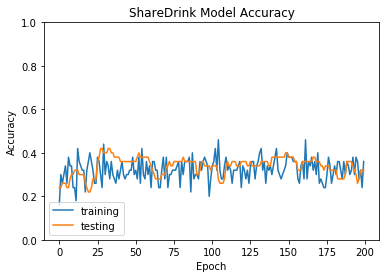

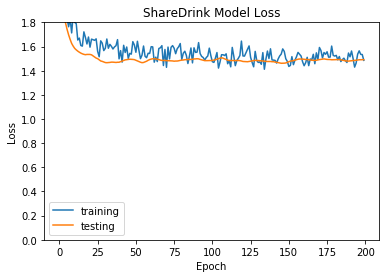

Largest Testing Accuracy ::  0.4200
Epoch 1st Appeared ::  27
Smallest Testing Loss ::  1.4614
Epoch 1st Appeared ::  145 

Highest Acc, Lowest Loss ::  0.4200 1.4668
Epoch 1st Appeared ::  32

--------------------------------------------------------------------------

Category ::  MeatWeek
Subcategories ::  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0] 

BACTERIA CLASS  P-VALUE
Actinobacteria  -- 0.0026

Total significant classes ::  1
Training size ::  50
Testing size ::  50


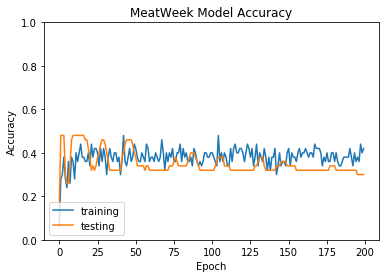

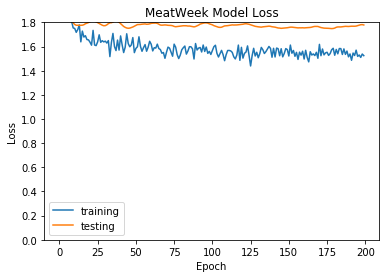

Largest Testing Accuracy ::  0.4800
Epoch 1st Appeared ::  1
Smallest Testing Loss ::  1.7484
Epoch 1st Appeared ::  178 

Highest Acc, Lowest Loss ::  0.4800 1.7755
Epoch 1st Appeared ::  13

--------------------------------------------------------------------------

Category ::  FreshWeek
Subcategories ::  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0] 

BACTERIA CLASS  P-VALUE
Clostridia  -- 0.0059
Flavobacteriia  -- 0.0036

Total significant classes ::  2
Training size ::  50
Testing size ::  51


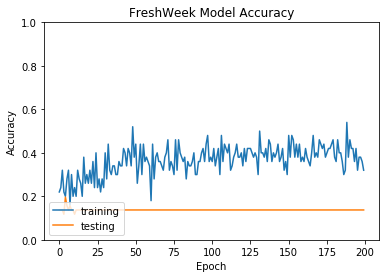

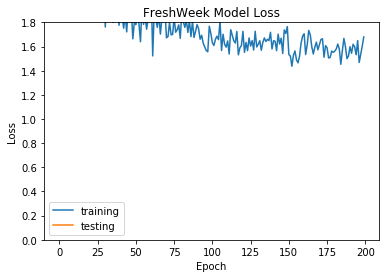

Largest Testing Accuracy ::  0.1961
Epoch 1st Appeared ::  4
Smallest Testing Loss ::  2.1148
Epoch 1st Appeared ::  65 

Highest Acc, Lowest Loss ::  0.1961 2.3559
Epoch 1st Appeared ::  4

--------------------------------------------------------------------------

Category ::  BrushTongue
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
Epsilonproteobacteria  -- 0.0456
Spirochaetes  -- 0.0099

Total significant classes ::  2
Training size ::  50
Testing size ::  50


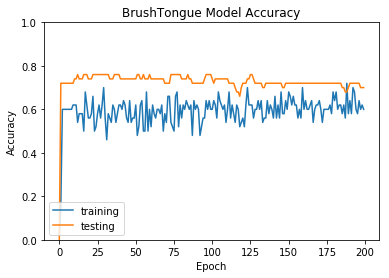

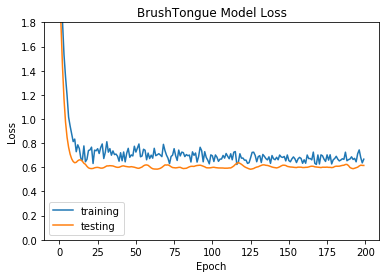

Largest Testing Accuracy ::  0.7600
Epoch 1st Appeared ::  55
Smallest Testing Loss ::  0.5843
Epoch 1st Appeared ::  125 

Highest Acc, Lowest Loss ::  0.7600 0.5843
Epoch 1st Appeared ::  125

--------------------------------------------------------------------------

Category ::  BrushTeethWeek
Subcategories ::  ['21-25', '0', '6-10', '11-15', '1-5', '16-20', '>25'] 

BACTERIA CLASS  P-VALUE
Fusobacteria  -- 0.0002

Total significant classes ::  1
Training size ::  51
Testing size ::  51


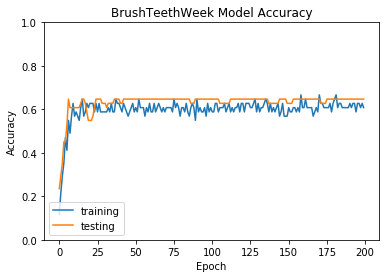

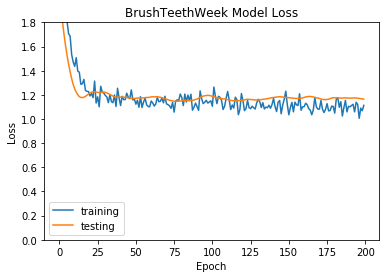

Largest Testing Accuracy ::  0.6471
Epoch 1st Appeared ::  6
Smallest Testing Loss ::  1.1467
Epoch 1st Appeared ::  75 

Highest Acc, Lowest Loss ::  0.6471 1.1467
Epoch 1st Appeared ::  75

--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  FlossWeek
Subcategories ::  ['21-25', '0', '11-15', '6-10', '1-5'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  DentistYear
Subcategories ::  ['0', '3', '>4', '1', '2', '4'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  Toothbrush
Subcategories ::  ['electric', 'both', 'manual'] 

BACTERIA CLASS  P-VALUE
Flavobacteriia  -- 0.0356

Total significant classes ::  1
Training size ::  51
Testing size ::  52


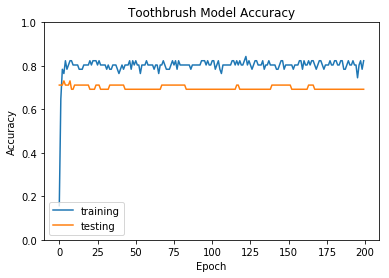

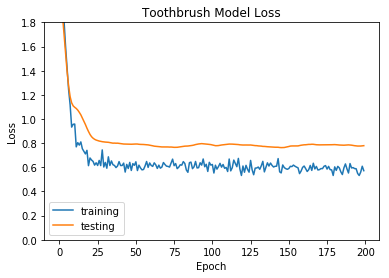

Largest Testing Accuracy ::  0.7308
Epoch 1st Appeared ::  3
Smallest Testing Loss ::  0.7631
Epoch 1st Appeared ::  145 

Highest Acc, Lowest Loss ::  0.7308 1.1850
Epoch 1st Appeared ::  7

--------------------------------------------------------------------------

Category ::  Mouthwash
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
Bacteroidia  -- 0.0060
Flavobacteriia  -- 0.0294

Total significant classes ::  2
Training size ::  53
Testing size ::  54


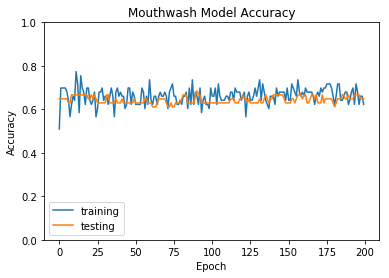

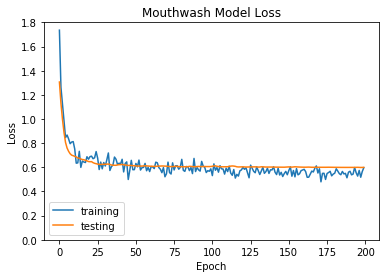

Largest Testing Accuracy ::  0.6852
Epoch 1st Appeared ::  90
Smallest Testing Loss ::  0.5987
Epoch 1st Appeared ::  197 

Highest Acc, Lowest Loss ::  0.6667 0.5992
Epoch 1st Appeared ::  189

--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  WashHandsEat
Subcategories ::  [1.0, 2.0, 3.0, 4.0, 5.0] 

BACTERIA CLASS  P-VALUE
Alphaproteobacteria  -- 0.0479
Nostocophycideae  -- 0.0318
Oscillatoriophycideae  -- 0.0410

Total significant classes ::  3
Training size ::  50
Testing size ::  51


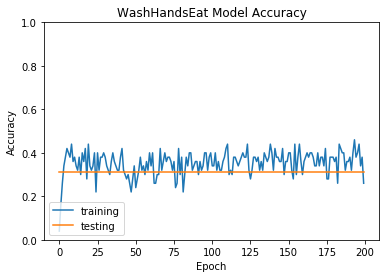

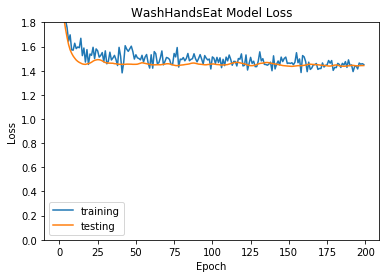

Largest Testing Accuracy ::  0.3137
Epoch 1st Appeared ::  0
Smallest Testing Loss ::  1.4356
Epoch 1st Appeared ::  152 

Highest Acc, Lowest Loss ::  0.3137 1.4356
Epoch 1st Appeared ::  152

--------------------------------------------------------------------------

Category ::  WashHandsRestroom
Subcategories ::  [2.0, 3.0, 4.0, 5.0] 

BACTERIA CLASS  P-VALUE
Betaproteobacteria  -- 0.0392

Total significant classes ::  1
Training size ::  50
Testing size ::  50


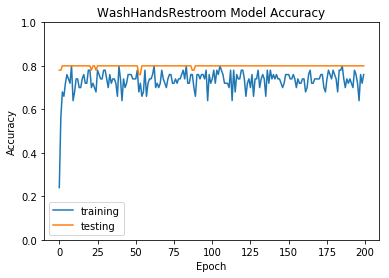

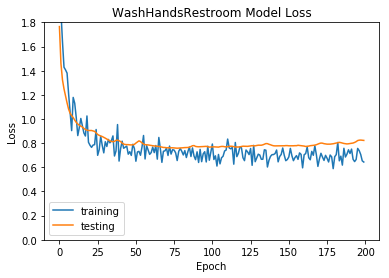

Largest Testing Accuracy ::  0.8000
Epoch 1st Appeared ::  2
Smallest Testing Loss ::  0.7582
Epoch 1st Appeared ::  77 

Highest Acc, Lowest Loss ::  0.8000 0.7582
Epoch 1st Appeared ::  77

--------------------------------------------------------------------------

Category ::  ChangeToothbrush
Subcategories ::  ['every three months', 'every year', 'every month'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  OrthoDevice
Subcategories ::  ['>5 years', '5 years', '2 years', '3 years', 'none', '4 years', '1 year'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  Device
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Categor

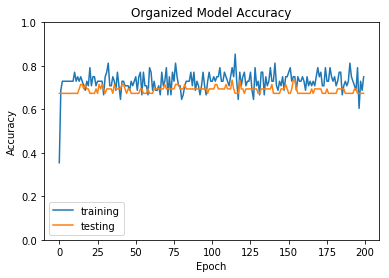

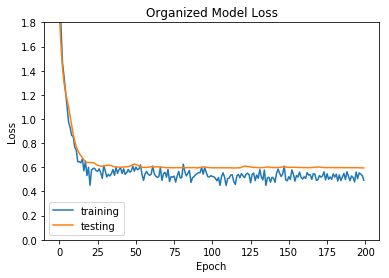

Largest Testing Accuracy ::  0.7347
Epoch 1st Appeared ::  113
Smallest Testing Loss ::  0.5942
Epoch 1st Appeared ::  114 

Highest Acc, Lowest Loss ::  0.7347 0.5947
Epoch 1st Appeared ::  113

--------------------------------------------------------------------------

Category ::  RateStress
Subcategories ::  [1.0, 2.0, 3.0, 4.0, 5.0] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  AvgSleep
Subcategories ::  ['7-8', '9-10', '5-6', '3-4', '1-2'] 

BACTERIA CLASS  P-VALUE
Gammaproteobacteria  -- 0.0396
Erysipelotrichi  -- 0.0225

Total significant classes ::  2
Training size ::  50
Testing size ::  51


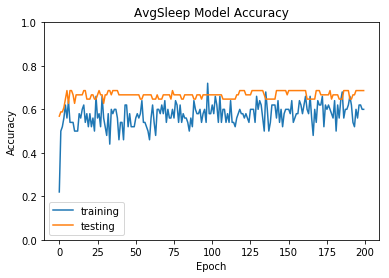

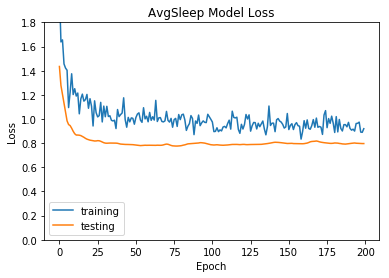

Largest Testing Accuracy ::  0.6863
Epoch 1st Appeared ::  7
Smallest Testing Loss ::  0.7760
Epoch 1st Appeared ::  77 

Highest Acc, Lowest Loss ::  0.6863 0.7989
Epoch 1st Appeared ::  38

--------------------------------------------------------------------------

Category ::  AvgWork
Subcategories ::  ['6-10', '11-15', '>31', '21-30', '1-5', '16-20'] 

BACTERIA CLASS  P-VALUE
Fusobacteria  -- 0.0082

Total significant classes ::  1
Training size ::  50
Testing size ::  50


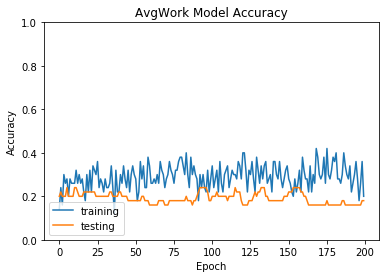

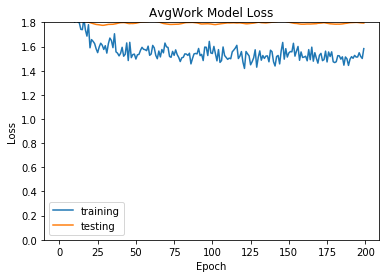

Largest Testing Accuracy ::  0.2400
Epoch 1st Appeared ::  92
Smallest Testing Loss ::  1.7756
Epoch 1st Appeared ::  28 

Highest Acc, Lowest Loss ::  0.2400 1.7865
Epoch 1st Appeared ::  93

--------------------------------------------------------------------------

Category ::  Setting
Subcategories ::  ['rural', 'suburb', 'medium town (10,000 - 100,000)', 'small town (<10,000 population)', 'large city (>100,000 - 1,000,000)', 'metroplex (>1,000,000)'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  UpDown
Subcategories ::  ['stairs', 'escalator', 'all equal amounts', 'elevator'] 

BACTERIA CLASS  P-VALUE
Sphingobacteriia  -- 0.0247

Total significant classes ::  1
Training size ::  49
Testing size ::  49


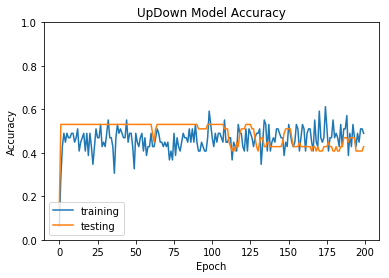

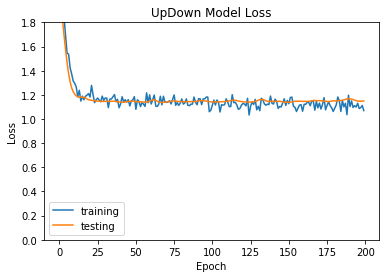

Largest Testing Accuracy ::  0.5306
Epoch 1st Appeared ::  1
Smallest Testing Loss ::  1.1374
Epoch 1st Appeared ::  67 

Highest Acc, Lowest Loss ::  0.5306 1.1374
Epoch 1st Appeared ::  67

--------------------------------------------------------------------------

Category ::  Weight
Subcategories ::  ['151-175', '226-250', '176-200', '201-225', '251-275', '126-150', '100-125', '<100'] 

BACTERIA CLASS  P-VALUE
Gammaproteobacteria  -- 0.0198
Fusobacteria  -- 0.0018

Total significant classes ::  2
Training size ::  49
Testing size ::  50


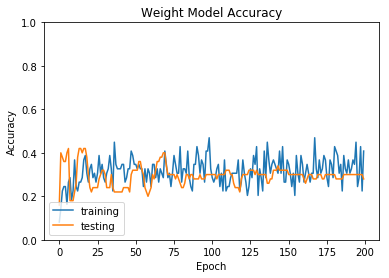

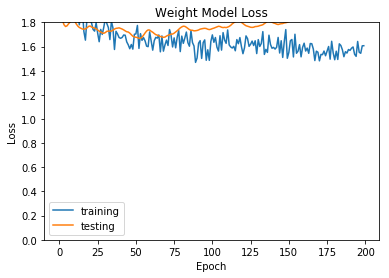

Largest Testing Accuracy ::  0.4200
Epoch 1st Appeared ::  6
Smallest Testing Loss ::  1.6673
Epoch 1st Appeared ::  52 

Highest Acc, Lowest Loss ::  0.4200 1.7436
Epoch 1st Appeared ::  16

--------------------------------------------------------------------------

Category ::  ExerciseMonth
Subcategories ::  ['7-8', '0', '9-10', '>10', '3-4', '5-6', '1-2'] 

BACTERIA CLASS  P-VALUE
Gammaproteobacteria  -- 0.0227

Total significant classes ::  1
Training size ::  49
Testing size ::  50


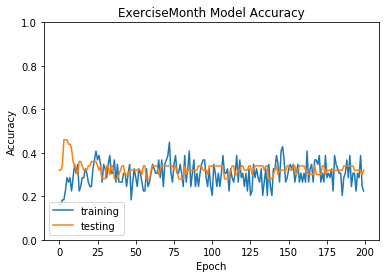

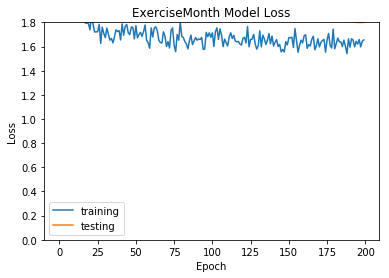

Largest Testing Accuracy ::  0.4600
Epoch 1st Appeared ::  3
Smallest Testing Loss ::  1.7987
Epoch 1st Appeared ::  196 

Highest Acc, Lowest Loss ::  0.4600 1.9024
Epoch 1st Appeared ::  4

--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  Orientation
Subcategories ::  ['homosexual', 'bisexual', 'heterosexual'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------


--------------------------------------------------------------------------


--------------------------------------------------------------------------

Category ::  ShareBathroom
Subcategories ::  ['0', '3', '1', '2', '>6', '5'] 

BACTERIA CLASS  P-VALUE
Epsilonproteobacteria  -- 0.0218

Total significant classes ::  1
Training size ::  49
Testing size ::  49


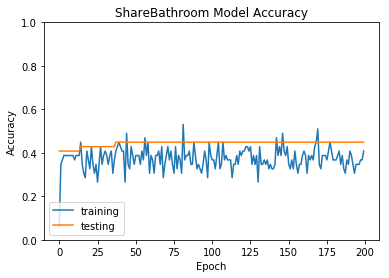

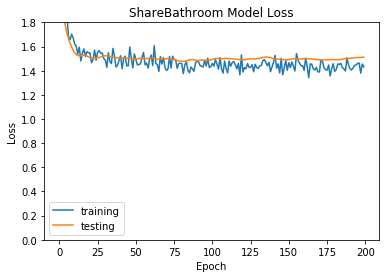

Largest Testing Accuracy ::  0.4490
Epoch 1st Appeared ::  37
Smallest Testing Loss ::  1.4756
Epoch 1st Appeared ::  81 

Highest Acc, Lowest Loss ::  0.4490 1.4756
Epoch 1st Appeared ::  81

--------------------------------------------------------------------------

Category ::  BooksYear
Subcategories ::  ['0', '11-15', '6-10', '1-5', '16-20', '>25'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  Alarms
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  Patience
Subcategories ::  ['often', 'usually', 'always', 'sometimes', 'never', 'rarely'] 

BACTERIA CLASS  P-VALUE
Bacteroidia  -- 0.0260
Betaproteobacteria  -- 0.0248
Epsilonproteobacteria  -- 0.0154

Total significant classes ::  3
Training size ::  48
Testing size ::  48


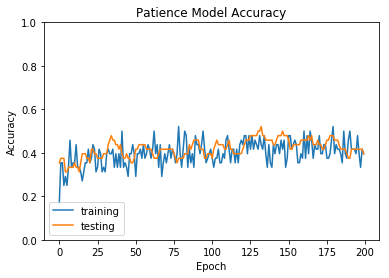

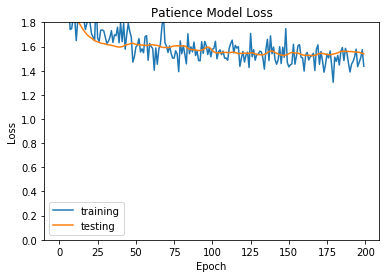

Largest Testing Accuracy ::  0.5208
Epoch 1st Appeared ::  132
Smallest Testing Loss ::  1.5239
Epoch 1st Appeared ::  165 

Highest Acc, Lowest Loss ::  0.5208 1.5302
Epoch 1st Appeared ::  132

--------------------------------------------------------------------------

Category ::  Lipstick
Subcategories ::  ['often', 'usually', 'always', 'sometimes', 'never', 'rarely'] 

BACTERIA CLASS  P-VALUE
Fusobacteria  -- 0.0007
Epsilonproteobacteria  -- 0.0432

Total significant classes ::  2
Training size ::  48
Testing size ::  49


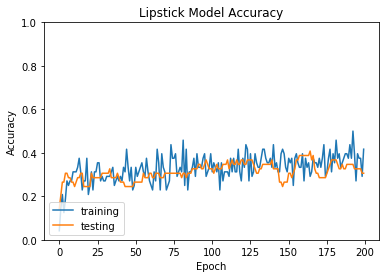

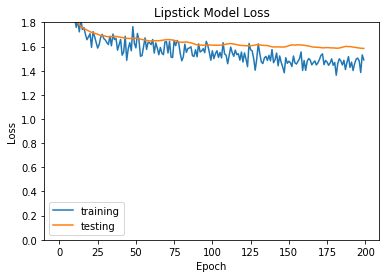

Largest Testing Accuracy ::  0.4082
Epoch 1st Appeared ::  164
Smallest Testing Loss ::  1.5843
Epoch 1st Appeared ::  199 

Highest Acc, Lowest Loss ::  0.4082 1.6005
Epoch 1st Appeared ::  164

--------------------------------------------------------------------------

Category ::  IntroExtro
Subcategories ::  ['ambivert', 'extrovert', 'introvert'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  Relgious
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  OptiPessi
Subcategories ::  ['pessimist', 'optimist'] 

BACTERIA CLASS  P-VALUE
Bacilli  -- 0.0096
Deltaproteobacteria  -- 0.0353
Mollicutes  -- 0.0458
Chlamydiia  -- 0.0461
GroupII  -- 0.0458

Total significant classes ::  5
Training size ::  49
Testing size ::  49


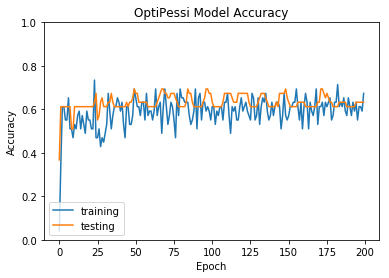

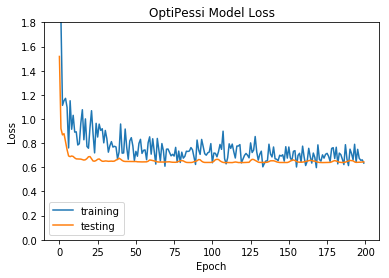

Largest Testing Accuracy ::  0.6939
Epoch 1st Appeared ::  49
Smallest Testing Loss ::  0.6390
Epoch 1st Appeared ::  108 

Highest Acc, Lowest Loss ::  0.6939 0.6395
Epoch 1st Appeared ::  171

--------------------------------------------------------------------------

Category ::  SexuallyActive
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  OralSex
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
Betaproteobacteria  -- 0.0275

Total significant classes ::  1
Training size ::  48
Testing size ::  49


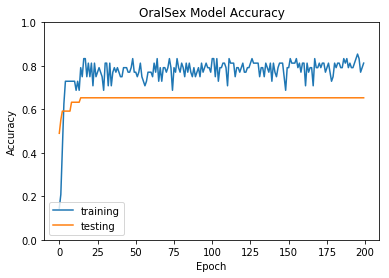

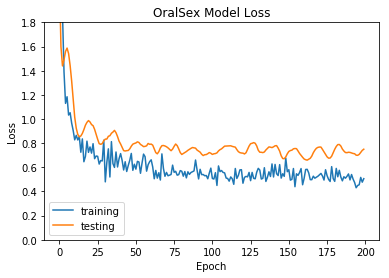

Largest Testing Accuracy ::  0.6531
Epoch 1st Appeared ::  14
Smallest Testing Loss ::  0.6594
Epoch 1st Appeared ::  162 

Highest Acc, Lowest Loss ::  0.6531 0.6594
Epoch 1st Appeared ::  162

--------------------------------------------------------------------------

Category ::  Music
Subcategories ::  [1.0, 2.0, 3.0, 4.0, 5.0] 

BACTERIA CLASS  P-VALUE
Fusobacteria  -- 0.0482
Deltaproteobacteria  -- 0.0067
Alphaproteobacteria  -- 0.0296

Total significant classes ::  3
Training size ::  48
Testing size ::  49


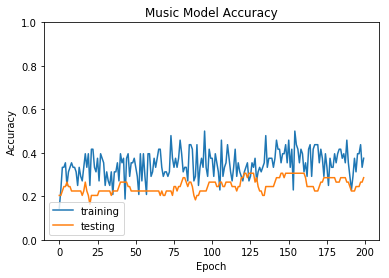

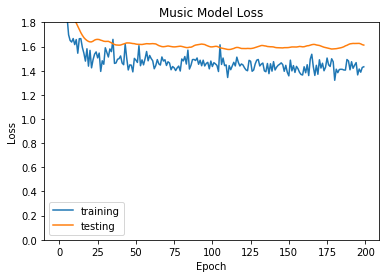

Largest Testing Accuracy ::  0.3061
Epoch 1st Appeared ::  121
Smallest Testing Loss ::  1.5753
Epoch 1st Appeared ::  111 

Highest Acc, Lowest Loss ::  0.3061 1.5831
Epoch 1st Appeared ::  122

--------------------------------------------------------------------------

Category ::  AvgGrade
Subcategories ::  ['c', 'b', 'a'] 

BACTERIA CLASS  P-VALUE
Bacteroidia  -- 0.0223
Deltaproteobacteria  -- 0.0319
Nostocophycideae  -- 0.0006

Total significant classes ::  3
Training size ::  49
Testing size ::  50


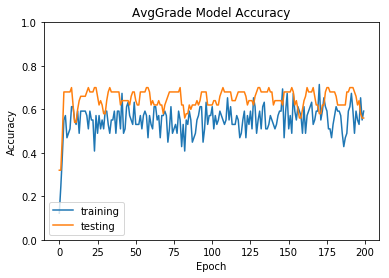

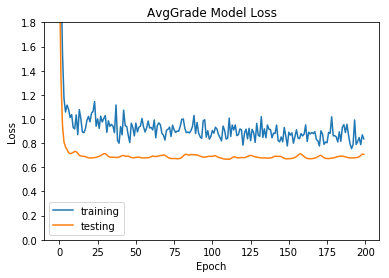

Largest Testing Accuracy ::  0.7000
Epoch 1st Appeared ::  8
Smallest Testing Loss ::  0.6667
Epoch 1st Appeared ::  111 

Highest Acc, Lowest Loss ::  0.7000 0.6712
Epoch 1st Appeared ::  107

--------------------------------------------------------------------------

Category ::  RateHappy
Subcategories ::  [1.0, 2.0, 3.0, 4.0, 5.0] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  Arts
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------

Category ::  Kiss
Subcategories ::  ['no', 'yes'] 

BACTERIA CLASS  P-VALUE
no significant classes

--------------------------------------------------------------------------




****** Overall Observations ********************************************************


Total significant categories ::  37 / 66

Top appearing classes :: 
[('Fusobacteria', 7), ('Eps

In [15]:

class Main():
    data = pd.read_csv('MasterSheet.csv')
    outputMap = {}
    showAllClasses = False
    global sumSigCat
    sumSigCat = 0
    global totalCat
    totalCat = 0
    global bactClassDict
    bactClassDict = {}
    
#     runTests(data, Col.OptiPessi, outputMap, showAllClasses)
    
    for x in range(1, 82):
        runTests(data, Col(x), outputMap, showAllClasses)
        print("\n--------------------------------------------------------------------------\n")
    
    print("\n\n\n****** Overall Observations ********************************************************\n")
    print("\nTotal significant categories :: ", repr(sumSigCat), "/", repr(totalCat))
    print("\nTop appearing classes :: ")
    sort = sorted(bactClassDict.items(), key=lambda x: x[1], reverse=True)
    print(sort)

In [16]:
import os 
    
os.system('jupyter nbconvert --to html Ttest-Anova-Calc.ipynb')

0